In [1]:
import pandas as pd
import numpy as np
import os
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import  string
from sklearn.metrics import classification_report
import nltk

# Loading Dataset

In [2]:
#loading the file
#df = pd.read_csv("C://Users//maheg//Desktop//Northwest Cadence Data//AB R Service//NorthWestCadence//Litigation//train.csv", encoding='iso-8859-1',  error_bad_lines=False)
df = pd.read_excel("C://Users//maheg//Desktop//Arbitration//LTPG_arbitration.xlsx", encoding='iso-8859-1',  error_bad_lines=False)

In [3]:
df.head()

,Client,Matter,Matter Open,Matter Description,WA Tkinit,WA Name,WA Title,WA Section,WA PG,Tindex,Tworkdt,Hrs Wkd,Task Code,Mtudef2,BA Tkinit,SA Tkinit,Time Entry Narrative
0,58257,402937,2011-03-03,Arbitration Defense,BERRN,"BERRETH, NOWELL",PARTNER,EQ,LITIGATION & TRIAL PRACTICE,23614657,2011-03-10,0.2,NaN,NaN,BERRN,BERRN,Telephone conference with Ron Coleman.
1,58257,402937,2011-03-03,Arbitration Defense,BOJKL,"BOJKO, LISA",ASSOCIATE,2006,LITIGATION & TRIAL PRACTICE,23652090,2011-03-11,2.4,NaN,NaN,BERRN,BERRN,Participate in conference call regarding prepa...
2,58257,402937,2011-03-03,Arbitration Defense,BERRN,"BERRETH, NOWELL",PARTNER,EQ,LITIGATION & TRIAL PRACTICE,23639736,2011-03-11,2.0,NaN,NaN,BERRN,BERRN,Preparation for and attendance upon call with ...
3,58257,402937,2011-03-03,Arbitration Defense,BERRN,"BERRETH, NOWELL",PARTNER,EQ,LITIGATION & TRIAL PRACTICE,23639735,2011-03-13,0.5,NaN,NaN,BERRN,BERRN,Review of underlying documentation.
4,58257,402937,2011-03-03,Arbitration Defense,BERRN,"BERRETH, NOWELL",PARTNER,EQ,LITIGATION & TRIAL PRACTICE,23669557,2011-03-14,0.7,NaN,NaN,BERRN,BERRN,Review of underlying documentation; emails reg...


In [4]:
df.shape

(46912, 17)

In [5]:
df.columns

Index(['Client', 'Matter', 'Matter Open', 'Matter Description', 'WA Tkinit',
       'WA Name', 'WA Title', 'WA Section', 'WA PG', 'Tindex', 'Tworkdt',
       'Hrs Wkd', 'Task Code', 'Mtudef2', 'BA Tkinit', 'SA Tkinit',
       'Time Entry Narrative'],
      dtype='object')

# Data preprocessing

In [4]:
df = df.dropna(subset=['Time Entry Narrative'])
df = df.dropna(subset=['Task Code'])

In [15]:
#fv_task_code - keeping only one digit
#df["Task Code"] = df["Task Code"].apply(lambda x: str(x)[0:2])

In [19]:
df.loc[:,['Time Entry Narrative', 'Task Code']].head(10)

,Time Entry Narrative,Task Code
2014,Draft proposed agenda for Samsung project meet...,34
2015,Review of Apple v. Samsung docket for informat...,S282
2016,Review of Apple v. Samsung trial transcript fo...,S282
2017,Review of public statements concerning the val...,S282
2018,Review of news reports regarding recent Samsun...,ARB
2019,Discuss action items with Matt Richardson and ...,S282
2020,Prepare materials for Samsung strategy meeting.,34
2021,Conference with Matt Richardson regarding stat...,ARB
2022,"Participate in teleconference with Ron Antush,...",S282
2023,Meeting with Matt Justus regarding Samsung pat...,S282


In [91]:
#df.groupby('Task Code')['Task Code'].count()

# Data Exploration

In [92]:
# # Mean time for each task code

#df.groupby("task_code").agg({"HoursWorked":["count", "mean", "std", "max", "min"]})

# Model Building - Predicting task codes

In [5]:
# label encoding
df = df.dropna(subset=['Task Code'])

from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
number.fit(df["Task Code"].astype("str"))
df["target"] = number.fit_transform(df["Task Code"].astype("str"))

In [55]:
number.inverse_transform(7)

C:\Users\maheg\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'26CF'

In [6]:
# test train split
from sklearn import model_selection
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['Time Entry Narrative'], df['target'])
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((18651,), (18651,), (6218,), (6218,))

In [7]:
# vectorize
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
count_vect.fit(df['Time Entry Narrative'])

X_train_counts = count_vect.transform(train_x)
X_test_counts = count_vect.transform(test_x)
X_train_counts.shape, X_test_counts.shape

((18651, 5365), (6218, 5365))

In [8]:
# stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()
analyzer = TfidfVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


#tfidf/stop words/stemming - vectorize
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_vect = TfidfVectorizer(analyzer = stemmed_words, token_pattern=r'\w{1,}', stop_words= "english")
#tfidf_vect.fit(df["timecard_narrative"])
X_train_tfidf = tfidf_vect.fit_transform(train_x)
X_test_tfidf  = tfidf_vect.transform(test_x)
X_train_tfidf.shape, X_test_tfidf.shape

((18651, 3556), (6218, 3556))

In [9]:
#SDG classifier
from sklearn.linear_model import SGDClassifier
svm = SGDClassifier()
clf = svm.fit(X_train_tfidf, train_y)
predicted  = clf.predict(X_test_tfidf)
np.mean(predicted ==test_y)

C:\Users\maheg\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.7272434866516565

In [10]:
#Random forest
from sklearn.ensemble import RandomForestClassifier
rf  = RandomForestClassifier(n_estimators= 30)
rf.fit(X_train_tfidf, train_y)
predicted_rf = rf.predict(X_test_tfidf)
np.mean(predicted_rf ==test_y)

0.747507237053715

In [11]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train_tfidf, train_y)
predicted_knn = neigh.predict(X_test_tfidf)
np.mean(predicted_knn ==test_y)

0.742039240913477

In [45]:
print(classification_report(test_y, predicted, target_names=None))

             precision    recall  f1-score   support

          0       0.78      0.70      0.74       999
          1       0.00      0.00      0.00         8
          2       0.00      0.00      0.00         0
          3       0.79      0.34      0.48        64
          6       1.00      0.67      0.80         3
          7       0.89      0.11      0.19        74
          8       1.00      0.67      0.80         3
          9       0.00      0.00      0.00        11
         10       0.75      0.39      0.52        38
         12       1.00      0.12      0.22         8
         14       0.78      0.69      0.74       252
         16       0.80      0.27      0.40        15
         17       0.00      0.00      0.00         3
         18       0.79      0.88      0.83       536
         19       0.00      0.00      0.00         1
         20       0.00      0.00      0.00         0
         22       1.00      1.00      1.00         3
         23       1.00      0.11      0.20   

C:\Users\maheg\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maheg\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [12]:
#predicting a random text
def Ab_narratives(string):
    series = pd.Series(string)
    X_  = tfidf_vect.transform(series)
    predicted_  = clf.predict(X_)
    return number.inverse_transform(predicted_)

In [14]:
Ab_narratives("conference with client")

C:\Users\maheg\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['ARB'], dtype=object)

# Time prediction

In [ ]:
#predicting the time ased on narratives

In [61]:
#df_ = df
df_ = df

In [62]:
#df = df[df["WA Title"] == "ASSOCIATE"]

In [63]:
df.shape

(46912, 17)

In [64]:
df = df.dropna(subset=['Time Entry Narrative'])
#df["target"] = number.fit_transform(df["Hrs Wkd"])
df["target"] = df["Hrs Wkd"]
df = df[(df.target > 0) & (df.target < 16) ]
from sklearn import model_selection
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['Time Entry Narrative'], df['target'])
train_x.shape, train_y.shape, test_x.shape, test_y.shape


from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
count_vect.fit(df['Time Entry Narrative'])

X_train_counts = count_vect.transform(train_x)
X_test_counts = count_vect.transform(test_x)
X_train_counts.shape, X_test_counts.shape


# stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()
analyzer = TfidfVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w.lower()) for w in analyzer(doc) if nltk.pos_tag(nltk.word_tokenize(w))[0][1] not in ("NNP" "IN") or w.isalpha())

 
#tfidf/stop words/stemming
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_vect = TfidfVectorizer(analyzer = stemmed_words, token_pattern=r'\w{1,}', stop_words= "english")
#tfidf_vect.fit(df["timecard_narrative"])
X_train_tfidf = tfidf_vect.fit_transform(train_x)
X_test_tfidf  = tfidf_vect.transform(test_x)
X_train_tfidf.shape, X_test_tfidf.shape

C:\Users\maheg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


((33663, 5455), (11222, 5455))

In [67]:
#KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train_tfidf, train_y)
predicted_knn = neigh.predict(X_test_tfidf)
r2_score(test_y, predicted_knn)

0.45381619618721447

In [68]:
#linear model
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train_tfidf, train_y)
predicted_lm = regr.predict(X_test_tfidf)
r2_score(test_y, predicted_lm)

0.364052005660391

In [70]:
#Random forest
from sklearn.ensemble import RandomForestRegressor
rf  = RandomForestRegressor(n_estimators=50)
rf.fit(X_train_tfidf, train_y)
predicted_rf = rf.predict(X_test_tfidf)
r2_score(test_y, predicted_rf)

0.5450145107456115

In [285]:
def Ab_narratives(string):
    series = pd.Series(string)
    X_  = tfidf_vect.transform(series)
    predicted_  = neigh.predict(X_)
    return predicted_
Ab_narratives("Reviewing and making edits to letter to Panel re discovery proposal conducting research regarding availability and potential pitfalls of requesting third-party discovery from SEC via FOIA requests")

array([4.82])

In [77]:
#SDG classifier
#### error #################
from sklearn.linear_model import SGDRegressor
svm = SGDRegressor()
clf = svm.fit(X_train_tfidf, train_y)
predicted  = clf.predict(X_test_tfidf)
r2_score(test_y, predicted)

C:\Users\maheg\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.2949880682750752

In [78]:
predrf = pd.Series(predicted_rf).reset_index(drop = True)
#predlm = pd.Series(predicted_lm).reset_index(drop = True)
#predknn = pd.Series(predicted_knn).reset_index(drop = True)
df_com  = pd.concat([test_x.reset_index(drop= True), test_y.reset_index(drop = True), predrf], axis = 1, ignore_index=False)
df_com.head(20)

,Time Entry Narrative,target,0
0,Attend and take notes during Realtek v. LSI RA...,6.5,6.072452
1,Call with C. Ramos-Mrosovsky to discuss case s...,0.5,1.489000
2,Revise draft technical section of the post-hea...,5.0,2.962299
3,Meet with A. Tuck and A. Brown regarding docum...,0.3,0.502000
4,Review and revise expert report of D. Kennedy.,1.9,3.442367
5,Review correspondence from Bird and Bird regar...,1.1,0.690000
6,Letter to the Tribunal and reviewing response ...,2.5,0.932000
7,Review cited materials within Nokia Post Respo...,0.4,1.454000
8,Conference call with Messrs. Pinto and Mitchel...,1.2,1.344000
9,Prepare for IV oral argument.,7.1,1.226148


C:\Users\maheg\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


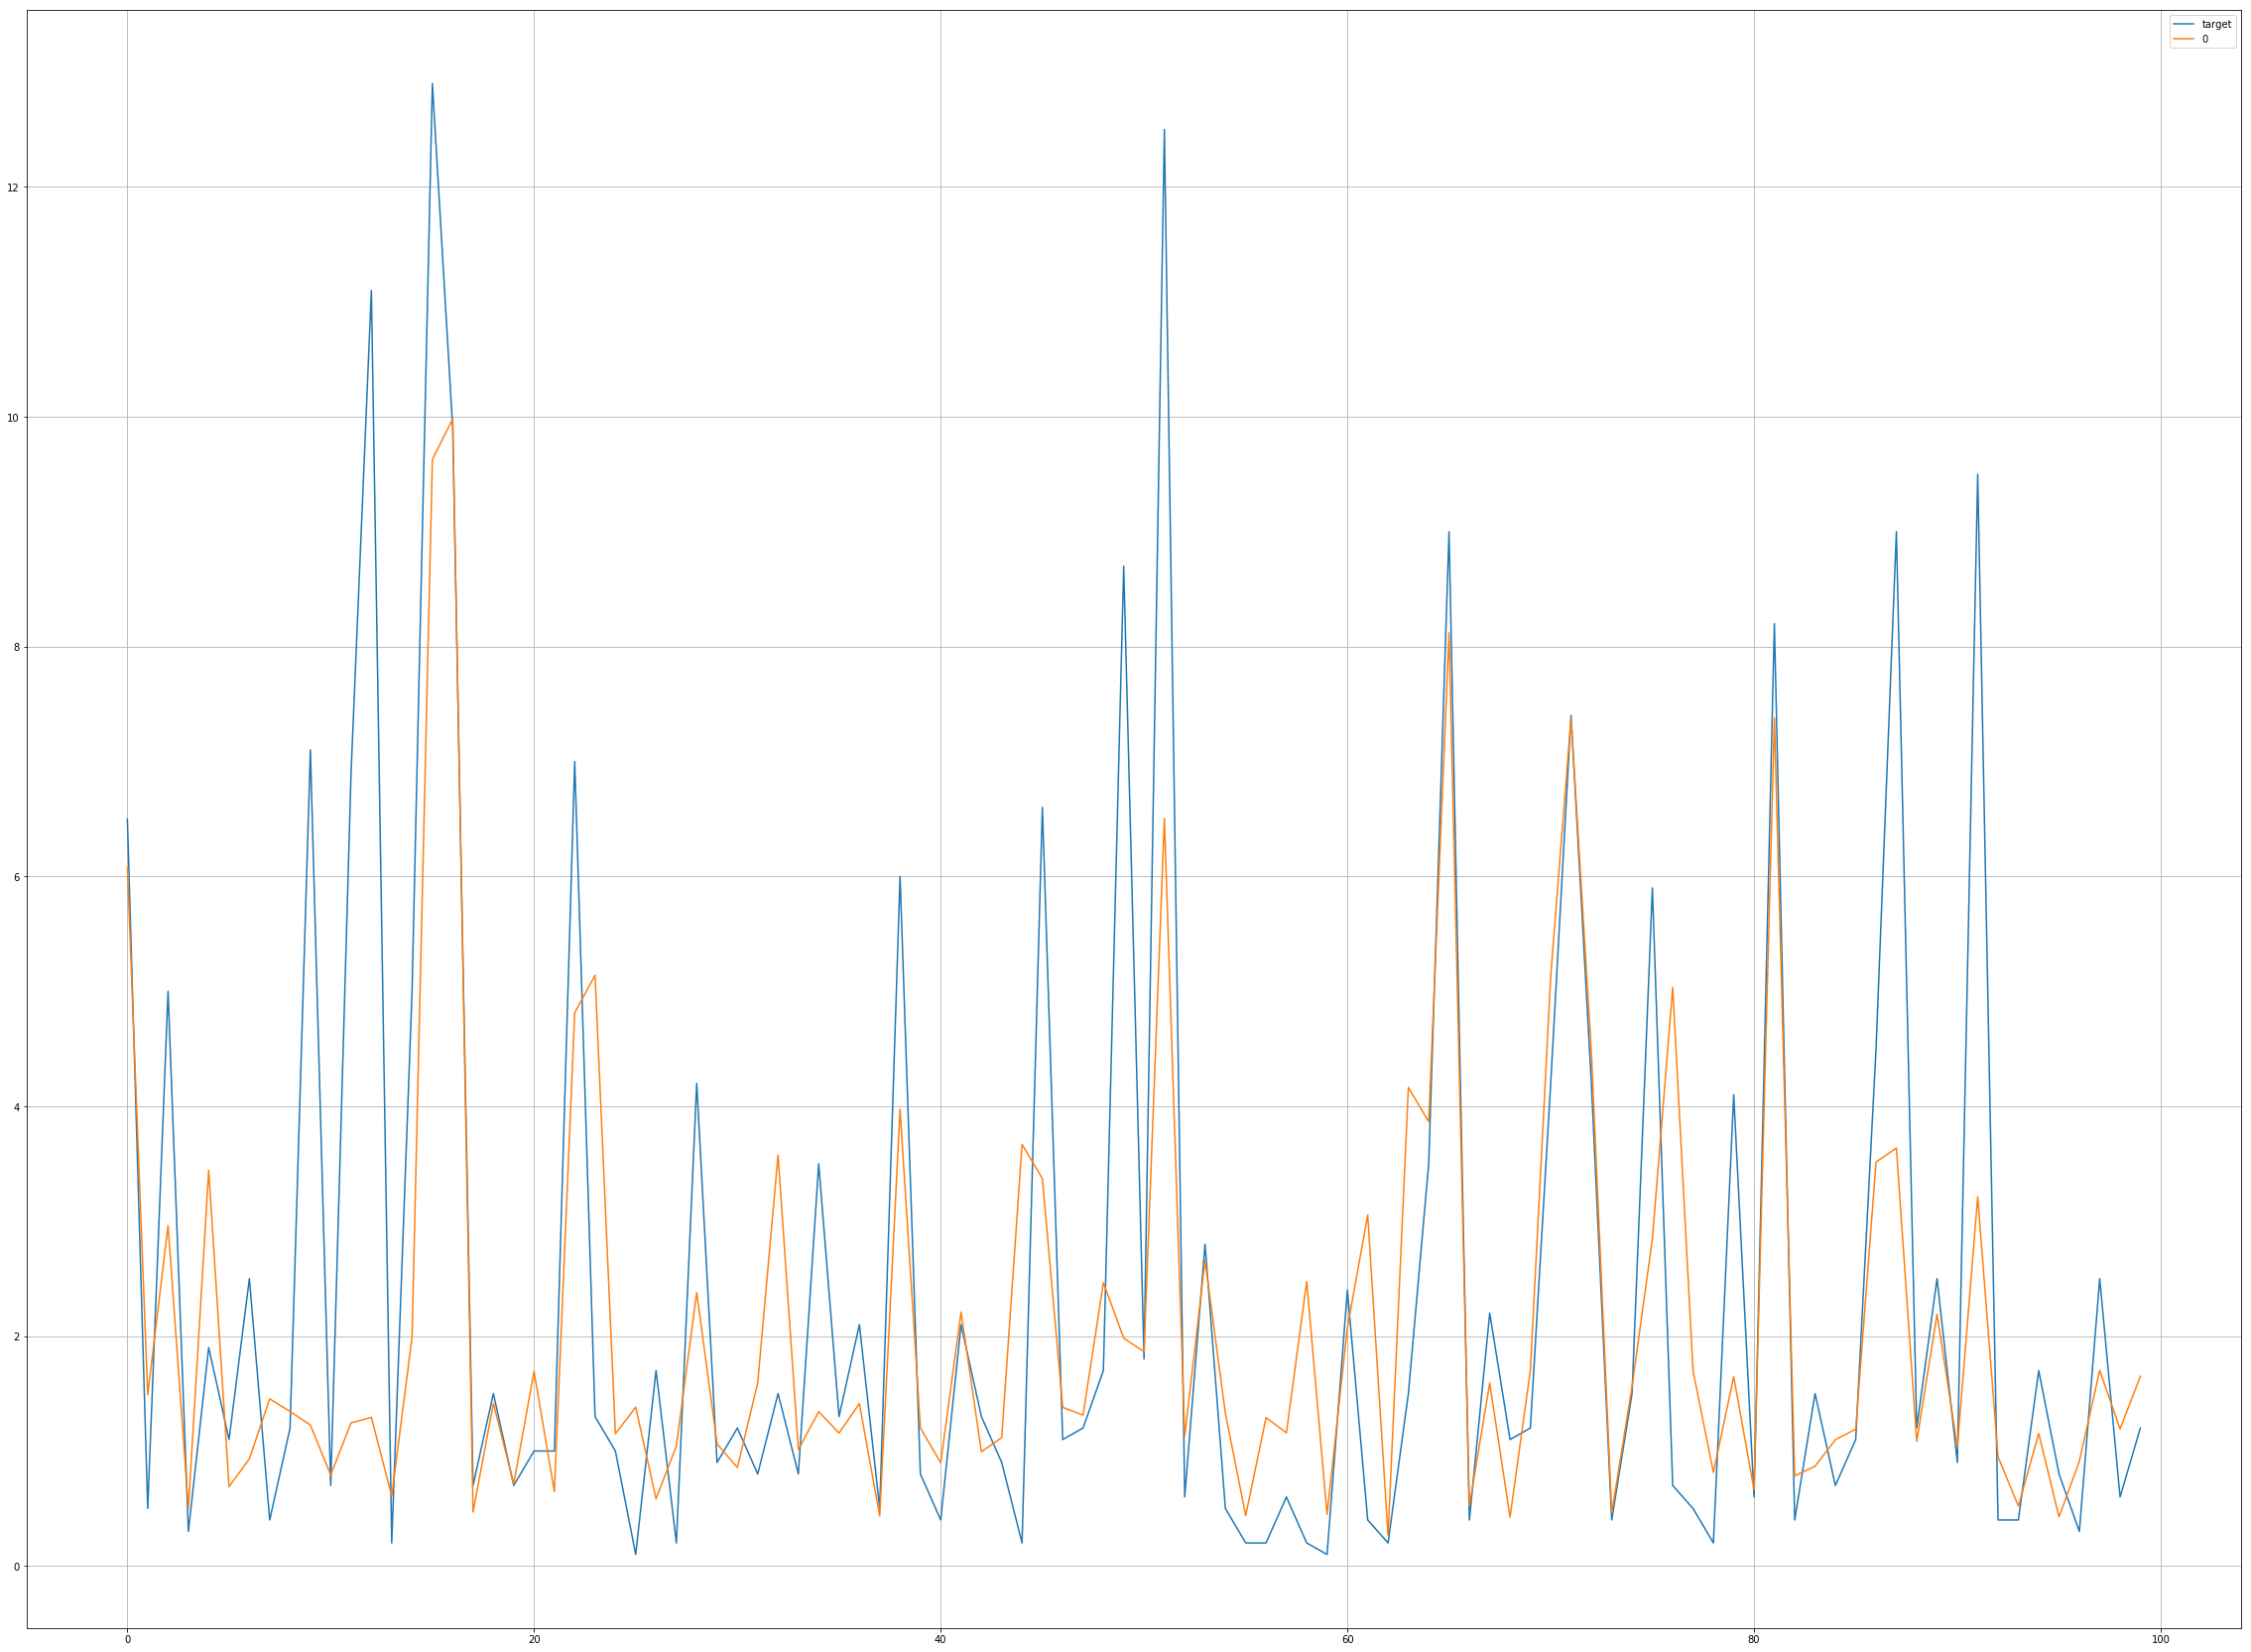

In [84]:
df_com[:100].plot( y=['target', 0], figsize=(40,30), grid=True)
#df_com.column

In [214]:
text1 = ''
for index, row in df.iterrows():
    text = row['Time Entry Narrative']
    text1 = text + text

In [ ]:
dict = {}
for w in text1.split():
    dict[stemmer.stem(w)] = nltk.pos_tag(nltk.word_tokenize(w))[0][1]

# To be done next

In [ ]:
# TO BE DONE NEXT
#words embedding
#Sentimentnlysis
#words length
#Pop tagging


In [ ]:
#topic modelling
'''
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
lda_model = LatentDirichletAllocation(n_topics=2, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(X_train_tfidf)
print(lda_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)



lda_test = lda_model.transform(X_test_tfidf)
from scipy.sparse import coo_matrix, hstack
xtrain_ = hstack([X_train_tfidf,lda_Z]).toarray()
xtest_ =  hstack([X_test_tfidf,lda_test]).toarray()
'''

# Checking on newdata- recent files